In [67]:
import datetime
import warnings
import itertools as it
import time
import concurrent.futures as cf

import dill
from arctic.exceptions import NoDataFoundException
from arctic import Arctic
from pymongo import MongoClient

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sympy import divisors

import ipyparallel as ipp
import ipywidgets as ipw
import ipyvolume as ipv
import qgrid

In [68]:
import kelp3d_objs as k3

In [69]:
def kelp_calculate(a_water, b, ns, na, kelp_profile, const, num_threads=1):
    from kelp3d_objs import f90
    import numpy as np
    from datetime import datetime
    import tempfile
    import time
    import yaml
    import pymongo
    import dill
    
    # Extract constants
    (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         num_scatters, gmres_flag, tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_flag, gmres_wrapper) = const
    
    dz = (zmax-zmin)/nz
    print("dz = {}".format(dz))
    
    num_vsf = na
    vsf_angles = np.linspace(0,np.pi, na)
    vsf_vals = 0*vsf_angles + 1/(4*np.pi)
    ns = int(ns)
    
    nomega = int(na*(na-2)+2)
    p_kelp = np.asfortranarray(np.zeros([ns,ns,nz]))
    radiance = np.asfortranarray(np.zeros([ns, ns, nz, nomega]))
    irradiance = np.asfortranarray(np.zeros([ns, ns, nz]))
    
    # z grid centers
    z = np.linspace(zmin+0.5*dz, zmax-0.5*dz, nz)
    
    # Start timer
    tic = time.time()
    
    
    # Kelp distribution profiles
    frond_length_funcs = {
        'top-heavy': 3.0 * z**2 * np.exp(-z) + 0.5,
        'bottom-heavy': 3.0 * (zmax-z)**2 * np.exp((z-zmax)) + 0.5,
        'uniform': 0*z + 1.0,
        'none': 0*z
    }
    
    # Top-heavy
    frond_lengths = frond_length_funcs[kelp_profile]
    #frond_lengths = np.ones(nz)
    frond_stds =  0.25 * frond_lengths
    num_fronds = 10 * np.ones(nz)
    water_speeds = 0.5 * np.ones(nz)
    water_angles = 2*np.pi / zmax * (z-zmin)
    
    fs = 0.5
    fr = 0.5
    ft = 1e-2
    
    print("theoretical max_kelp = {}".format(num_fronds.max()*ft/dz))
    
    a_kelp = absorptance_kelp / ft
    
    # Generate kelp
    f90.gen_kelp(
        xmin, xmax,
        ymin, ymax,
        zmin, zmax,
        frond_lengths,
        frond_stds,
        num_fronds,
        water_speeds,
        water_angles,
        fs, fr, ft,
        p_kelp
    )
    
    print("Max kelp = {}".format(p_kelp.max()))
    
    # Calculate light field
    f90.calculate_light_field(
        xmin, xmax,
        ymin, ymax,
        zmin, zmax,
        na, na,
        a_water, a_kelp, b,
        vsf_angles, vsf_vals,
        theta_s, phi_s, I0, decay,
        tol_abs, tol_rel, maxiter_inner, maxiter_outer,
        p_kelp, radiance, irradiance,
        num_scatters, gmres_flag, gmres_wrapper,
    )
    
    # End timer
    toc = time.time()
    date = datetime.now()
    
    compute_results = {
        'duration': toc - tic,
        'date': date,
        'radiance': radiance,
        'irradiance': irradiance,
        'p_kelp': p_kelp
    }
    
    # Load database connection info
    with open("/global/homes/o/oevans/.mongo.yaml") as fh:
        config = yaml.load(fh)
    # Open database
    mongo = pymongo.MongoClient(**config)[config['authSource']]
    coll = mongo['kelp-gridstudy']
    # Write compute results to file
    with tempfile.NamedTemporaryFile(prefix='/global/cscratch1/sd/oevans/kelp-gridstudy/result', mode='wb', delete=False) as fh:
        dill.dump(compute_results, fh)
        results_path = fh.name
        
    # Save inputs and results path to database
    coll.insert_one({
        'a_water': a_water,
        'b': b,
        'ns': ns,
        'na': na,
        'kelp_profile': kelp_profile,
        'const': dill.dumps(const),
        'date': date,
        'gmres_flag': const[19],
        'num_scatters': const[13],
        'results_path': results_path
    })
        
    return compute_results

In [70]:
def kelp_visualize(duration, date, radiance, irradiance, p_kelp):
    print("Computation finished {}".format(date))
    print("Took {:.2f} seconds".format(duration))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        kelpfig = ipv.figure()
        ipv.volshow(p_kelp.T, controls=False)
        # set initial angle
        kelpfig.anglex = 0.85 * np.pi
        kelpfig.angley = -0.30 * np.pi
        kelpfig.anglez = -0.67 * np.pi
        
        irradfig = ipv.figure()
        ipv.volshow(irradiance.T, controls=False)
        # set initial angle
        irradfig.anglex = 0.85 * np.pi
        irradfig.angley = -0.30 * np.pi
        irradfig.anglez = -0.67 * np.pi
        
        
    rad_text = "Rad Stats<br>---------<br>min: {:.3e}<br>max: {:.3e}<br>mean: {:.3e}<br>std: {:.3e}".format(
        radiance.min(),
        radiance.max(),
        radiance.mean(),
        radiance.std()
    )
        
    irrad_text = "Irrad Stats<br>-----------<br>min: {:.3e}<br>max: {:.3e}<br>mean: {:.3e}<br>std: {:.3e}".format(
        irradiance.min(),
        irradiance.max(),
        irradiance.mean(),
        irradiance.std()
    )
        
    display(ipw.HBox([
        kelpfig, 
        irradfig,
        ipw.Box(layout=ipw.Layout(width='10px')),
        ipw.HTML("<tt>{}<br><br>{}</tt>".format(rad_text, irrad_text))
    ]))


In [182]:
# Hard-coded parameters
absorptance_kelp = 0.8 # (%)
rope_spacing = 5.0 # (m)
zmin, zmax = 0.0, 10.0 # (m)
nz=4

# Light from above
I0 = 50.0 # (W/m^2)
phi_s = 0 # (rad)
theta_s = 0 # (rad)
decay = 0 # (?) - light (practically) only from directly above

# Calculated or otherwise boring parameters
xmin = -rope_spacing/2
xmax = rope_spacing/2
ymin = -rope_spacing/2
ymax = rope_spacing/2

# Solver parameters
num_scatters = 0
gmres_flag = False
tol_abs = 1e-6
tol_rel = 1e-6
maxiter_inner = 200
maxiter_outer = 200
gmres_wrapper = k3.gmres_wrapper

const = (rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         num_scatters, gmres_flag, tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_flag, gmres_wrapper)

In [183]:
a_water = 0.5
b = 0.05
ns = 10
na = 10
kelp_profile = 'top-heavy'
compute_results = kelp_calculate(
    a_water,
    b,
    ns,
    na,
    kelp_profile,
    const
)

dz = 2.5
theoretical max_kelp = 0.04
Max kelp = 0.006292104042514887
GMRES Success!


In [185]:
ipv.quickvolshow(compute_results['irradiance'])

In [190]:
gmres_results;

In [272]:
# Run asymptotic cases
res_list = []
save_list = []

p_kelp = gmres_results['p_kelp']
true_irrad = gmres_results['irradiance']
true_perceived_irrad = np.sum(p_kelp*true_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1)) / np.pi

const_copy = list(const)

for n in range(max_scatter+1):
    print("n={}".format(n))
    # Set GMRES flag False
    const_copy[19] = False
    # Set num_scatter
    const_copy[13] = n
    #print("const={}".format(const))
    compute_results = kelp_calculate(
        a_water,
        b,
        ns,
        na,
        kelp_profile,
        const_copy, num_threads=1
    )

    print("ns={}".format(run['ns']))
    irrad = compute_results['irradiance']
    # Perceived irradiance for each depth layer
    perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    err = np.abs(true_perceived_irrad - perceived_irrad)
    rad_err = np.mean(compute_results['radiance'] - gmres_results['radiance'])

    save_vals = {
        'abs_err': err,
        'rel_err': err / np.abs(true_perceived_irrad),
        'perceived_irrad': perceived_irrad,
        'irradiance': irrad,
        'abs_rad_err': rad_err,
        'rel_rad_err': rad_err / np.abs(result['radiance'])
    }

    res_list.append(compute_results)
    save_list.append(save_vals)

n=0
dz = 2.5
theoretical max_kelp = 0.04
Max kelp = 0.006292104042514887
ns=12
n=1
dz = 2.5
theoretical max_kelp = 0.04
Max kelp = 0.006292104042514887
ns=12
n=2
dz = 2.5
theoretical max_kelp = 0.04
Max kelp = 0.006292104042514887
ns=12
n=3
dz = 2.5
theoretical max_kelp = 0.04
Max kelp = 0.006292104042514887
ns=12


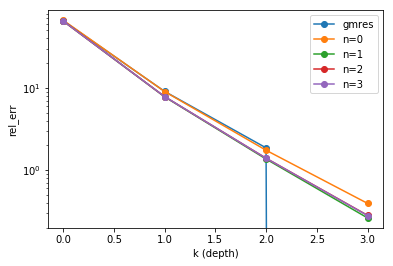

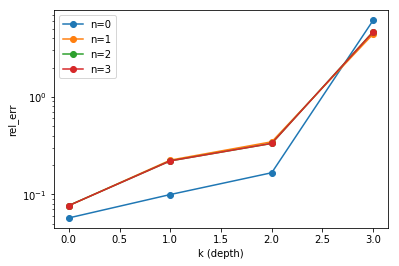

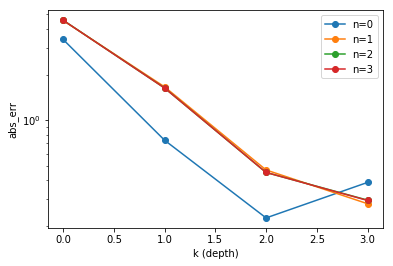

In [274]:
plt.figure()
plt.plot(gmres_results['irradiance'].mean(axis=(0,1))/np.pi, 'o-', label='gmres')
for n, irrad in enumerate([s['irradiance'] for s in save_list]):
    plt.plot(irrad.mean(axis=(0,1)), 'o-', label='n={}'.format(n))
plt.yscale('log')
plt.legend()
plt.xlabel('k (depth)')
plt.ylabel('rel_err')

plt.figure()
for n, err in enumerate([s['rel_err'] for s in save_list]):
    plt.plot(err, 'o-', label='n={}'.format(n))
plt.yscale('log')
plt.legend()
plt.xlabel('k (depth)')
plt.ylabel('rel_err')

plt.figure()
for n, err in enumerate([s['abs_err'] for s in save_list]):
    plt.plot(err, 'o-', label='n={}'.format(n))
plt.yscale('log')
plt.legend()
plt.xlabel('k (depth)')
plt.ylabel('abs_err')

plt.show()

In [155]:
import yaml
import pymongo
with open("/global/homes/o/oevans/.mongo.yaml") as fh:
    config = yaml.load(fh)
# Open database
mongo = pymongo.MongoClient(**config)[config['authSource']]
coll = mongo['kelp-gridstudy']

grid_sizes = set([(c['ns'], c['na']) for c in coll.find({'gmres_flag': True})])
grid_sizes
# Look at everything in the last day
#yesterday = datetime.datetime.now() - datetime.timedelta(days=1)

# Get results
#for record in coll.find({'date': {'$gte': yesterday}, 'gmres_flag': True}):
#    print(record['a_water'])
#    print(record['b'])
#    print(record['gmres_flag'])
#    print(record['num_scatters'])
#    #print(record['irradiance'].mean())


{(4, 4),
 (4, 6),
 (4, 8),
 (6, 4),
 (6, 6),
 (6, 8),
 (8, 4),
 (8, 6),
 (12, 4),
 (12, 6),
 (24, 4)}

In [156]:
import ipyvolume as ipv

# Load GMRES Light Field & Compare to Asymptotics

In [147]:
ns = 12
na = 6
max_scatter = 3
runs = [c for c in coll.find({'gmres_flag': True, 'ns': ns, 'ns': ns})]
compute_results_list = []
true_save_list = []
save_list = []
for i, run in enumerate(runs):
    with open(run['results_path'], 'rb') as fh:
        result = dill.load(fh)
    const = list(dill.loads(run['const']))
    print(result['duration'])
    print([{k: v} for k, v in run.items() if type(v) in [str, float, int]])
    
    # Run asymptotic cases
    inner_res_list = []
    inner_save_list = []
    print("A")
    
    p_kelp = result['p_kelp']
    true_irrad = result['irradiance']
    true_perceived_irrad = np.sum(p_kelp*true_irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
    
    true_save = {
        'perceived_irrad': true_perceived_irrad
    }
    
    true_save_list.append(true_save)
    
    for n in range(max_scatter+1):
        print("n={}".format(n))
        # Set GMRES flag False
        const[19] = False
        # Set num_scatter
        const[13] = n
        #print("const={}".format(const))
        compute_results = kelp_calculate(
            run['a_water'], 
            run['b'], 
            run['ns'], 
            run['na'], 
            run['kelp_profile'],
            const, num_threads=1
        )
        
        print("ns={}".format(run['ns']))
        irrad = compute_results['irradiance']
        # Perceived irradiance for each depth layer
        perceived_irrad = np.sum(p_kelp*irrad, axis=(0,1)) / np.sum(p_kelp, axis=(0,1))
        err = np.abs(true_perceived_irrad - perceived_irrad)
        rad_err = np.mean(compute_results['radiance'] - result['radiance'])
        
        save_vals = {
            'abs_err': err,
            'rel_err': err / np.abs(true_perceived_irrad),
            'perceived_irrad': perceived_irrad,
            'abs_rad_err': rad_err,
            'rel_rad_err': rad_err / np.abs(result['radiance'])
        }
        
        inner_res_list.append(compute_results)
        inner_save_list.append(save_vals)
    compute_results_list.append([inner_res_list])
    save_list.append(inner_save_list)

46.18942975997925
[{'a_water': 0.05}, {'b': 0.05}, {'ns': 12}, {'na': 4}, {'kelp_profile': 'top-heavy'}, {'num_scatters': 0}, {'results_path': '/global/cscratch1/sd/oevans/kelp-gridstudy/resultoargmq_e'}]
A
n=0
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.01564300256111505
ns=12
n=1
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.01564300256111505
ns=12
n=2
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.01564300256111505
ns=12
n=3
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.01564300256111505
ns=12
26.544074058532715
[{'a_water': 0.5}, {'b': 0.05}, {'ns': 12}, {'na': 4}, {'kelp_profile': 'top-heavy'}, {'num_scatters': 0}, {'results_path': '/global/cscratch1/sd/oevans/kelp-gridstudy/result85hrh92i'}]
A
n=0
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.01564300256111505
ns=12
n=1
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.01564300256111505
ns=12
n=2
dz = 1.0
theoretical max_kelp = 0.1
Max kelp = 0.01564300256111505
ns=12
n=3
dz = 1.0
theoretical max_kelp = 0.1
Max kel

In [148]:
true_save_list[0]['perceived_irrad']

array([ 348.17332497,  170.27576386,   66.73875942,   22.80854795,
          7.22475235,    1.4536814 ,   -0.42988883,   -1.33212553,
         -1.38758275,   -1.13823974])

In [149]:
[s['perceived_irrad'] for s in save_list[0]]

[array([  1.76984728e+02,   1.30936528e+02,   5.62642079e+01,
          1.72032855e+01,   6.98552563e+00,   3.29234787e+00,
          1.00589332e+00,   8.05379818e-01,   4.64647509e-01,
          1.45215396e-01]),
 array([ 176.4967114 ,  128.53938181,   56.07176314,   19.61539768,
          10.30290598,    6.6985811 ,    4.37467664,    4.28302074,
           3.39120072,    2.14492435]),
 array([ 175.53028359,  127.00403645,   54.66991632,   18.5656147 ,
           9.27042276,    5.68007132,    3.5312882 ,    3.18171958,
           2.34579739,    1.45800901]),
 array([ 175.82683923,  127.47444328,   55.10078471,   18.82812464,
           9.49525625,    5.8987747 ,    3.66671838,    3.41187957,
           2.59539645,    1.6048601 ])]

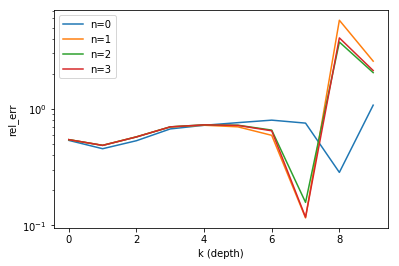

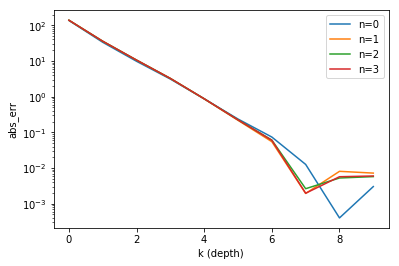

In [153]:
plt.figure()
for n, err in enumerate([s['rel_err'] for s in save_list[1]]):
    plt.plot(err, label='n={}'.format(n))
plt.yscale('log')
plt.legend()
plt.xlabel('k (depth)')
plt.ylabel('rel_err')

plt.figure()
for n, err in enumerate([s['abs_err'] for s in save_list[1]]):
    plt.plot(err, label='n={}'.format(n))
plt.yscale('log')
plt.legend()
plt.xlabel('k (depth)')
plt.ylabel('abs_err')

plt.show()

In [94]:
A.sum(axis=(1,2))

array([ 36, 117, 198])

In [86]:
for n, asym_run in enumerate(compute_results_list[0]):
    err = asym_run - runs[0]

[[{'duration': 0.05227351188659668,
   'date': datetime.datetime(2018, 5, 3, 10, 0, 0, 824884),
   'radiance': array([[[[ 48.7654956 ,  47.56147123,  47.56147123, ...,   0.        ,
               0.        ,   0.        ],
            [ 46.37629954,  42.9220087 ,  42.90347056, ...,   0.        ,
               0.        ,   0.        ],
            [ 44.08730644,  35.76008658,  35.25197568, ...,   0.        ,
               0.        ,   0.        ],
            ..., 
            [ 34.3220739 ,  21.72846739,  20.98777402, ...,   0.        ,
               0.        ,   0.        ],
            [ 32.64816661,  18.98371542,  18.51846036, ...,   0.        ,
               0.        ,   0.        ],
            [ 31.05589673,  16.6236382 ,  15.32799709, ...,   0.        ,
               0.        ,   0.        ]],
   
           [[ 48.7654956 ,  47.56147123,  47.56147123, ...,   0.        ,
               0.        ,   0.        ],
            [ 46.36044478,  42.76847622,  42.96642777, ..

In [13]:
import dill

In [25]:
const = dill.loads(res[0]['const'])
(rope_spacing, zmin, zmax, nz, I0, phi_s, theta_s, decay, xmin, xmax, ymin, ymax, absorptance_kelp,
         num_scatters, gmres_flag, tol_abs, tol_rel, maxiter_inner, maxiter_outer, gmres_flag, gmres_wrapper) = const

50.0

In [24]:
const

(5.0,
 0.0,
 10.0,
 10,
 50.0,
 0,
 0,
 0,
 -2.5,
 2.5,
 -2.5,
 2.5,
 0.8,
 0,
 True,
 1e-06,
 1e-06,
 200,
 200,
 True,
 <function kelp3d_objs.gmres_wrapper(row, col, data, sol, rhs, maxiter_outer, maxiter_inner, tol_abs, tol_rel)>)

In [16]:
with open(res[0]['results_path'], 'rb') as fh:
    result = dill.load(fh)

In [21]:
res[0]['gmres_flag']

True

In [19]:
ipv.quickvolshow(result['p_kelp'].T)

/global/homes/o/oevans/local/miniconda3/envs/kelp/lib/python3.6/site-packages/ipyvolume/serialize.py:66: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [18]:
ipv.quickvolshow(result['irradiance'].T)